# Twitter 감정 분석 - 로지스틱 회귀
> Twitter sentiment analysis - Logistic Regression
- https://www.kaggle.com/code/kevinmorgado/twitter-sentiment-analysis-logistic-regression
- 목차
   - Initial data transformation
   - Plotting features
   - Text analysis
   - Logistic Regression model
   - XGBoost model
    - Final Remarks

## 1. 초기 데이터 변환
> Initial data transformation
- 데이터 시각화, 텍스트 분석, 텍스트 벡터화, 모델 생성을 위한 라이브러리
- 영어 stopwords는 nltk 라이브러리에서 다운로드

In [1]:
# pip install nltk

In [86]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None #하나의 컬럼에 대한 값을 변경할 때 발생할 수 있는 경고 메시지 방지
import os #파일 경로용
from wordcloud import WordCloud # 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer # 데이터 변환용

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression # 예측 모델용
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import re # 정규표현식

import nltk
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 데이터 로드(Train, Validation)

In [6]:
val = pd.read_csv('./twitter_validation.csv', header = None)
train = pd.read_csv('./twitter_training.csv', header = None)

In [12]:
# 컬럼명 수정
train.columns = ['id', 'information', 'type', 'text']
train.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [14]:
val.columns = ['id', 'information', 'type', 'text']
val.head()

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [15]:
train_data = train
train_data

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [17]:
val_data = val
val_data

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


### 텍스트 분석 전처리
- str.lower 를 사용해서 모든 텍스트를 소문자로 바꿔준다.
- 단, 숫자로만 존재하는 텍스트가 있는데 이런 데이터도 문자형으로 바꿔준다.
- 다음으로 정규표현식을 사용하여 Twitter에서 일반적으로 발생하는 입력 오류(특수 문자 등)를 제거한다

In [81]:
# 텍스트 변환(소문자로)
train_data['lower'] = train_data.text.str.lower()
val_data['lower'] = val_data.text.str.lower()

# 모든 값을 '문자형'으로
train_data['lower'] = [str(data) for data in train_data.lower]
val_data['lower'] = [str(data) for data in val_data.lower]

# 영문 대문자, 영문 소문자, 숫자, 공백 문자(space)를 제외한 모든 문자를 공백 문자로 대체
# 즉, 특수 문자나 기호 등은 모두 제거
train_data['lower'] = train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
val_data['lower'] = val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [25]:
train_data.head()

,id,information,type,text,lower
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


## 2. 워드클라우드 시각화
> Plotting features
- 어떤 단어가 가장 많이 쓰였는지 시각화해보자

In [31]:
# "lower" 컬럼의 텍스트를 모두 결합
word_cloud_text = ''.join(train_data[train_data['type']=='Positive'].lower)

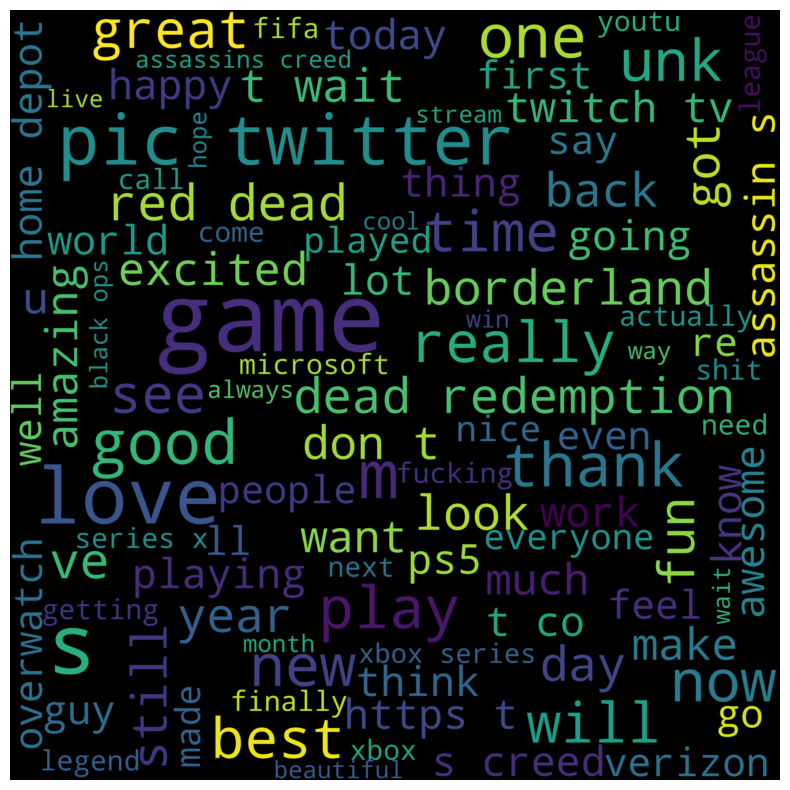

In [34]:
# 긍정적 멘트 시각화
wordcloud = WordCloud(max_font_size = 100,
                     max_words = 100,
                     background_color = 'black',
                     scale = 10,
                     width = 800,
                     height = 800).generate(word_cloud_text)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = 'bilinear') #  이미지의 보간(interpolation) 방법을 'bilinear'로 설정;이미지를 부드럽게 표시
plt.axis('off')
plt.show()

In [41]:
# 부정적 멘트 시각화
word_cloud_text = ''.join(train_data[train_data['type']=='Irrelevant'].lower)

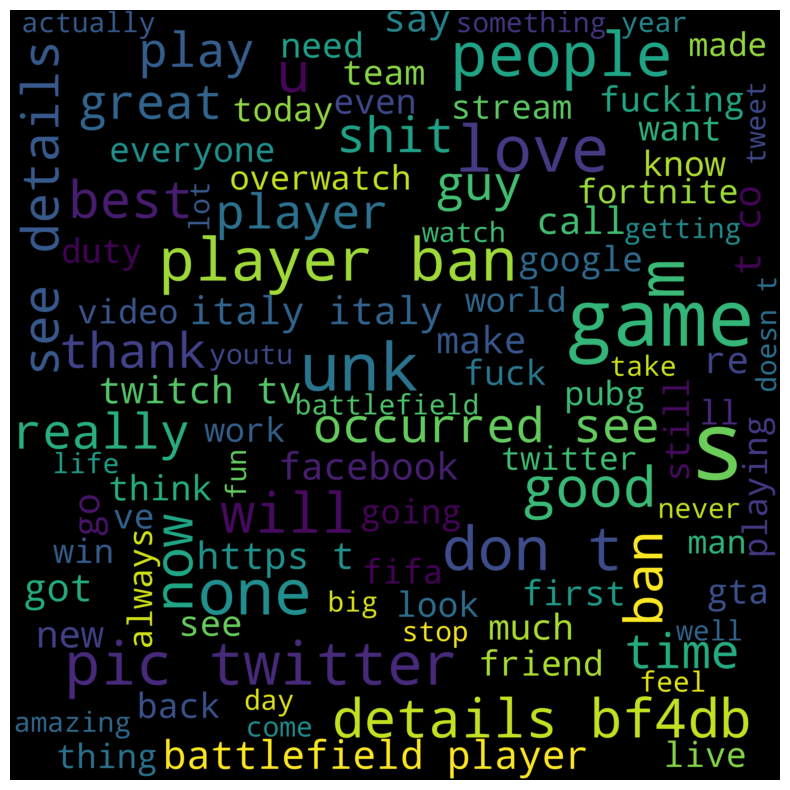

In [43]:
wordcloud = WordCloud(max_font_size = 100,
                     max_words = 100,
                     background_color = 'black',
                     scale = 10,
                     width = 800,
                     height = 800).generate(word_cloud_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

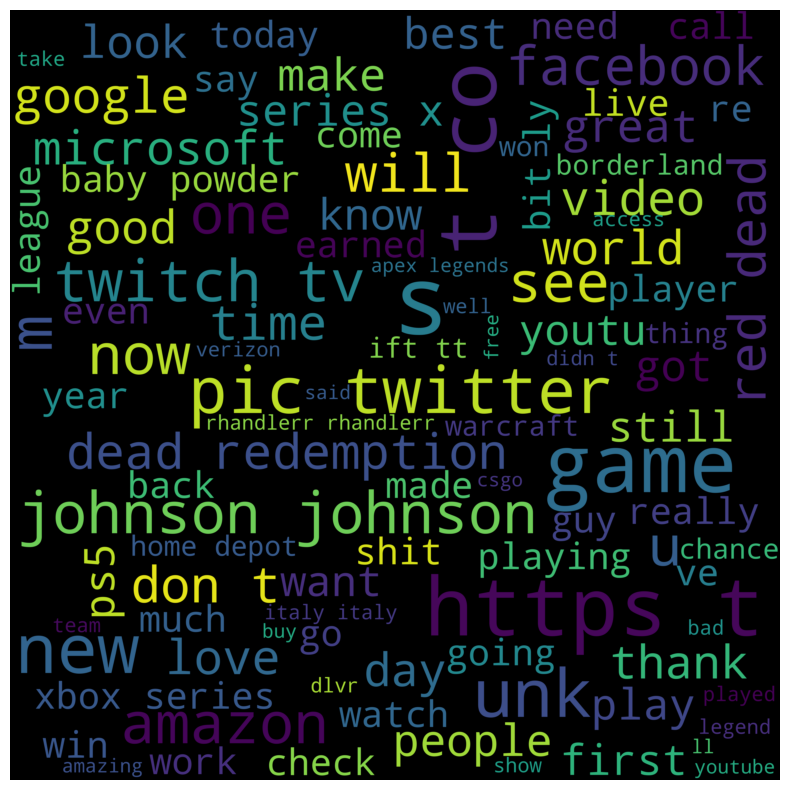

In [44]:
# 중립적 멘트 시각화
word_cloud_text = ''.join(train_data[train_data["type"]=="Neutral"].lower)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 브랜드를 구분하여 결과 확인
- 특정 브랜드별로 감성 텍스트 확인

In [45]:
train.head()

,id,information,type,text,lower
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


In [52]:
plot1 = train.groupby(['information', 'type']).count().reset_index()
plot1.head()

,information,type,id,text,lower
0,Amazon,Irrelevant,192,186,192
1,Amazon,Negative,576,575,576
2,Amazon,Neutral,1236,1207,1236
3,Amazon,Positive,312,308,312
4,ApexLegends,Irrelevant,192,192,192


> 결과를 보면 id의 개수와 lower 컬럼의 개수가 동일함을 알 수 있다.

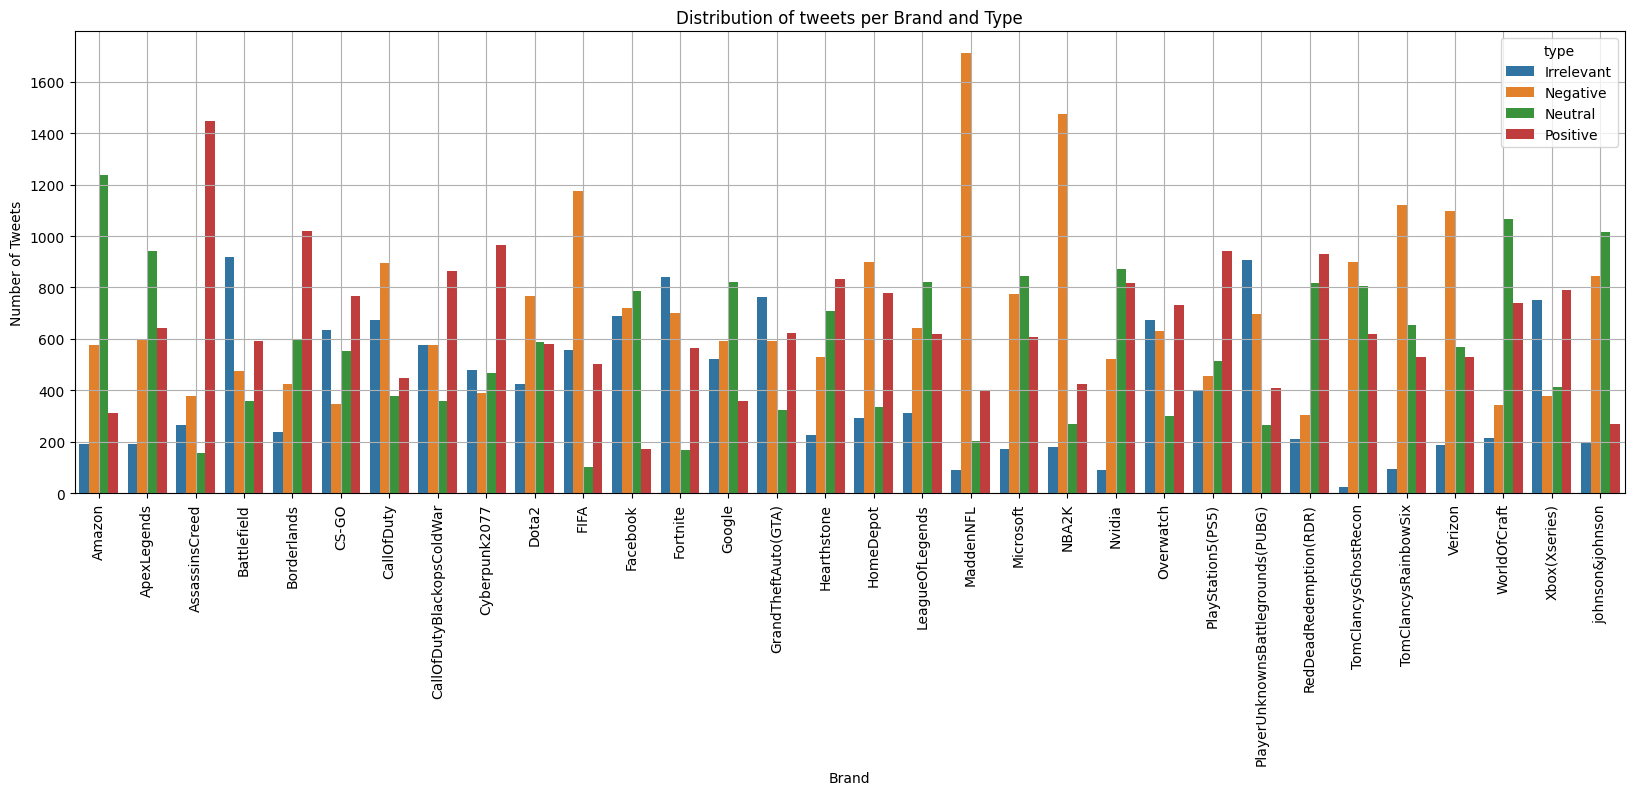

In [54]:
# 브랜드에 따라 결과 시각화

plt.figure(figsize = (20, 6))
sns.barplot(data=plot1, x = 'information', y='id', hue='type')
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Number of Tweets')
plt.grid()
plt.title('Distribution of tweets per Brand and Type')
plt.show()

> MaddenNFL 와 NBA2K 브랜드의 부정적 반응이 특히 높다

## 3. 텍스트 분석
- 정제된 텍스트로부터 모델의 복잡성을 식별하기 위해 초기 고유 토큰 수를 계산 
- 결과를 보면, 3만 개 이상의 고유한 단어가 있음

In [58]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/angela/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [87]:
# 텍스트 분리
tokens_text = [word_tokenize(str(word)) for word in train_data.lower]
tokens_text[:1]

[['im',
  'getting',
  'on',
  'borderlands',
  'and',
  'i',
  'will',
  'murder',
  'you',
  'all']]

In [66]:
# 중첩된 리스트인 tokens_text를 평탄하게 만들어서 모든 요소를 하나의 리스트에 포함
tokens_counter = [item for sublist in tokens_text for item in sublist]
tokens_counter[:10]

['im',
 'getting',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'all']

In [64]:
print('Number of tokens: ', len(set(tokens_counter)))

Number of tokens:  30436


In [68]:
tokens_text[1]

['i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all']

In [69]:
# stopwords 다운로드
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

## 4. 로지스틱 회귀 모델(1차)
> Logistic Regression model
---
- 주요 회귀 모델로는 sklearn 라이브러리의 간단한 로지스틱 회귀 모델을 사용 & Bag of Words (BoW) 접근 방식이 함께 사용
- 모델이 적절한 추세를 식별하는 데 도움이 되도록 관련 데이터를 분류하고 그룹화하는 데 도움이 됨
---
- n-gram은 자연어 처리에서 연속된 단어나 문자의 그룹을 나타내는 방법으로, 문장 또는 텍스트에서 패턴과 구조를 파악에 도움이 됨
- n은 그룹의 크기를 나타내는 숫자로, 일반적으로 1-gram, 2-gram (또는 바이그램), 3-gram (또는 트라이그램) 등으로 표현됨
<br>

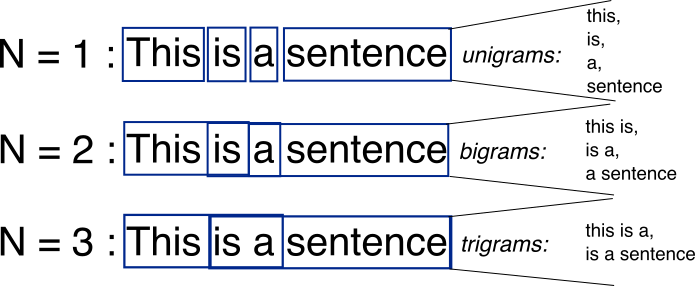

- 첫 번째 Bag of Words (BoW)에서는 불용어(stopwords)와 기본 n-gram 값으로 1을 고려

In [70]:
# 초기 Bag of Words
bow_counts = CountVectorizer(tokenizer = word_tokenize,
                             stop_words = stop_words,
                             ngram_range = (1, 1))

In [71]:
# train data를 분리
reviews_train, reviews_test = train_test_split(train_data, test_size = 0.2, random_state = 0)

In [72]:
# train 데이터 인코딩
X_train_bow = bow_counts.fit_transform(reviews_train.lower)

# 동일한 인코더로 test 데이터 인코딩
X_test_bow = bow_counts.transform(reviews_test.lower)

In [73]:
X_test_bow

<14937x29110 sparse matrix of type '<class 'numpy.int64'>'
	with 241743 stored elements in Compressed Sparse Row format>

In [74]:
y_train_bow = reviews_train['type']
y_test_bow = reviews_test['type']

In [77]:
# 긍정, 부정의 비율이 높음
y_test_bow.value_counts() / y_test_bow.shape[0]

Negative      0.299190
Positive      0.282252
Neutral       0.245632
Irrelevant    0.172926
Name: type, dtype: float64

In [78]:
# 로지스틱 회귀 모델 생성
## C :모델의 정규화 파라미터(1은 중간정도의 정규화)
model1 = LogisticRegression(C=1, solver='liblinear', max_iter=200)
model1.fit(X_train_bow, y_train_bow)

# 예측
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred)*100)

Accuracy:  83.95929570864297


In [82]:
# validation data
X_val_bow = bow_counts.transform(val_data.lower)
y_val_bow = val_data['type']

In [84]:
X_val_bow

<1000x29110 sparse matrix of type '<class 'numpy.int64'>'
	with 18629 stored elements in Compressed Sparse Row format>

In [85]:
Val_res = model1.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_res)*100)

Accuracy:  94.19999999999999


## 5. 2차 로지스틱 회귀 모델
- stopwords 사용하지 않고 n-gram 4를 사용하여 전체 데이터를 모두 사용

In [88]:
# n-gram 4
bow_counts = CountVectorizer(tokenizer=word_tokenize,
                            ngram_range=(1, 4))

In [89]:
# 데이터 라벨링
X_train_bow = bow_counts.fit_transform(reviews_train.lower)
X_test_bow = bow_counts.transform(reviews_test.lower)
X_val_bow = bow_counts.transform(val_data.lower)

/Users/angela/opt/anaconda3/envs/mulcamp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [90]:
X_train_bow

<59745x1427378 sparse matrix of type '<class 'numpy.int64'>'
	with 4142213 stored elements in Compressed Sparse Row format>

In [91]:
model2 = LogisticRegression(C=0.9, solver='liblinear', max_iter=1500)
model2.fit(X_train_bow, y_train_bow)
test_pred_2 = model2.predict(X_test_bow)

print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2)*100)

Accuracy:  90.79467095132891


In [92]:
y_val_vow = val_data['type']
Val_pred_2 = model2.predict(X_val_bow)

print("Accuracy: ", accuracy_score(y_val_vow, Val_pred_2)*100)

Accuracy:  98.6


In [101]:
Val_pred_2[:3]

array(['Irrelevant', 'Neutral', 'Negative'], dtype=object)

## 6. XGBoost 접근법
- 데이터 변환을 마쳤으니, 다른 예측 모델도 사용해보자

In [98]:
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_train_bow)
y_test_bow_num = le.transform(y_test_bow)
y_val_bow_num = le.transform(y_val_bow)

In [99]:
y_train_bow_num

array([3, 2, 3, ..., 0, 0, 1])

- 'multi:softmax'는 다중 클래스 분류 문제임을 나타냄
    - XGBoost는 각 클래스에 대한 확률을 계산하기 위해 소프트맥스 함수를 사용
- 1000개의 의사 결정 트리를 작성
- 각 트리를 구축할 때 무작위로 샘플링될 특성(열)의 분수를 제어; 0.6의 값을 가지면 각 트리 구성 시 특성의 60%가 고려
- 학습 데이터의 60%가 각 트리에 무작위로 샘플링됨

In [103]:
%%time

XGB = XGBClassifier(objective='multi:softmax', n_estimators=1000, colsample_bytree=0.6, subsample=0.6)
XGB.fit(X_train_bow, y_train_bow_num)

test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2)*100)

Accuracy:  84.93673428399276
CPU times: user 14h 5min 37s, sys: 20min 2s, total: 14h 25min 39s
Wall time: 2h 58min 58s


In [104]:
y_val_bow = val_data['type']
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2)*100)

Accuracy:  95.6


In [106]:
test_pred_N = XGB.predict(X_train_bow)
print("Accuracy: ", accuracy_score(y_train_bow_num, test_pred_N)*100)

Accuracy:  93.53418696125199


### 마무리
- 간단한 자연어 처리(NLP) 접근 방식을 통해 초기 섹션에서 나타난 레이블링 문제에도 불구하고 테스트 데이터셋에서 90% 정확도를 얻음
- xgboost에서 정확도가 낮아졌으니, 파라미터 조정이나 구체화된 분석이 필요해 보임